
🚀 Đang chạy LightGBM với tham số 'Heavy Hitter'...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 1354, number of used features: 7
[LightGBM] [Info] Start training from score 170.587554
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	valid_0's rmse: 9.85607	valid_0's l2: 97.1422
----------------------------------------
🏆 LIGHTGBM MANUAL TUNED - KẾT QUẢ:
📊 Q_Liquid R2: 0.4394 (RF ~ 0.42)
🛢️ Q_Oil    R2: 0.7953 (RF ~ 0.80)
----------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


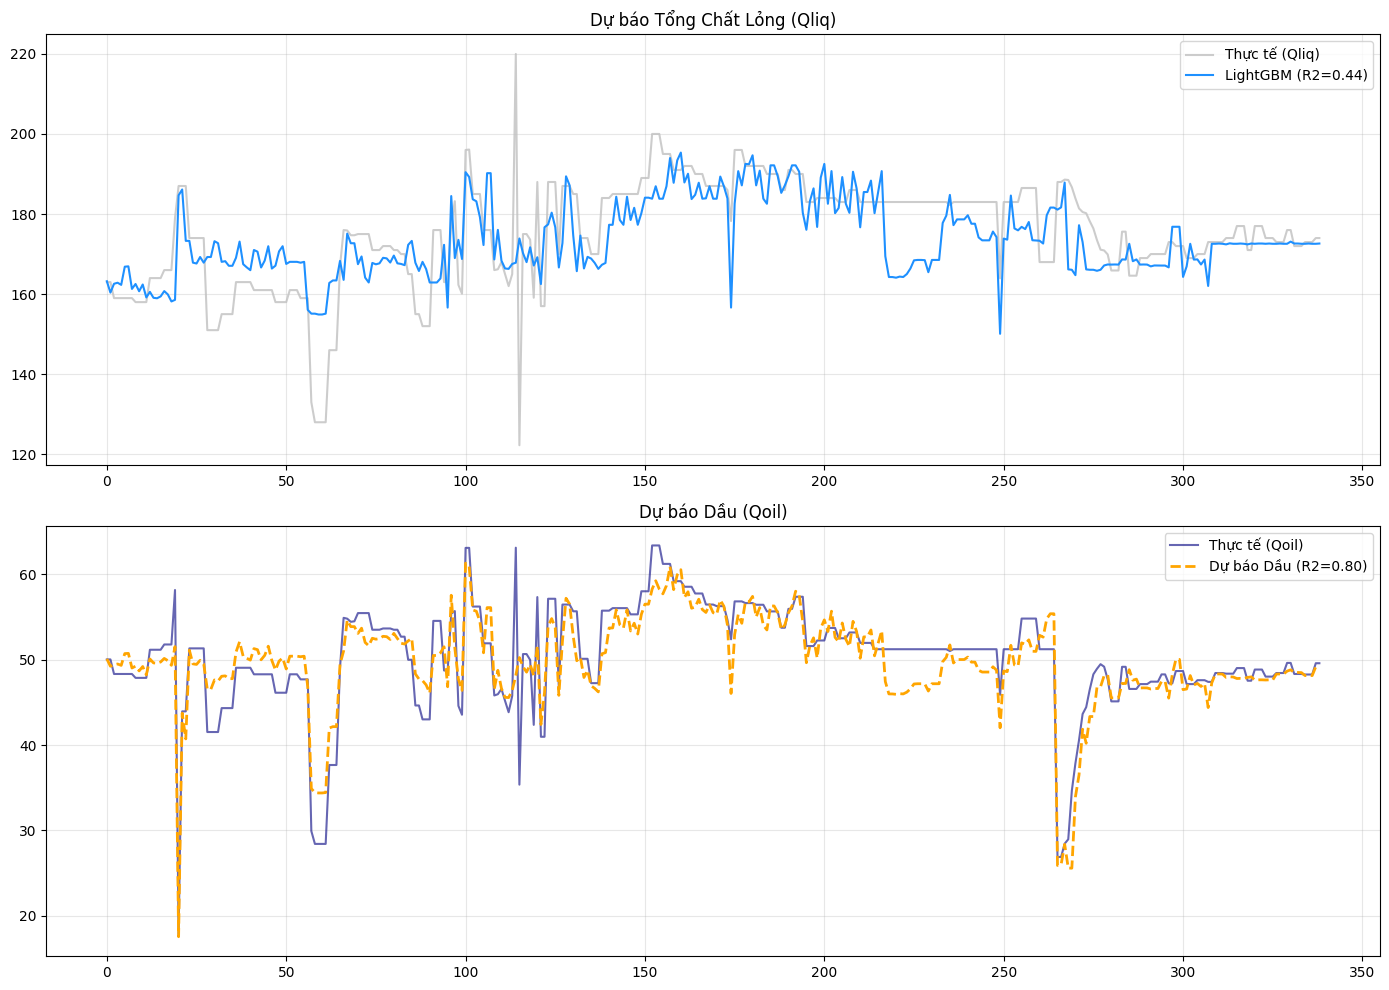

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ==========================================
# 1. CẤU HÌNH & TẢI DỮ LIỆU
# ==========================================
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
TEST_RATIO = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

df = pd.read_csv(FILE_PATH)

# ==========================================
# 2. XỬ LÝ TARGET & FEATURES (GIỮ NGUYÊN TỪ RF)
# ==========================================
if 'Water cut' in df.columns and 'Qoil' in df.columns:
    df['Water_cut_decimal'] = df['Water cut'] / 100
    df['Qliq_target'] = df.apply(
        lambda row: row['Qoil'] / (1 - row['Water_cut_decimal'])
        if (1 - row['Water_cut_decimal']) > 0.01 else np.nan,
        axis=1
    )
    df_clean = df.dropna(subset=['Qliq_target']).reset_index(drop=True)
else:
    raise ValueError("Thiếu dữ liệu cần thiết")

# Tạo các cột trung bình từ min-max
pair_features = {
    "Annulus pressure": ["Annulus pressure min", "Annulus pressure max"],
    "Buffer pressure": ["Buffer pressure min", "Buffer pressure max"],
    "T": ["T min", "T max"],
    "Flow pressure": ["Flow pressure min", "Flow pressure max"]
}

for new_col, cols in pair_features.items():
    col_min, col_max = cols
    if col_min in df_clean.columns and col_max in df_clean.columns:
        df_clean[f"{new_col}_avg"] = (df_clean[col_min] + df_clean[col_max]) / 2

features = [
    "Gas injection rate",
    "Annulus pressure_avg",
    "Buffer pressure_avg",
    "T_avg",
    "Flow pressure_avg",
    "Choke",
    "Downtime"
]

# Kiểm tra sự tồn tại của features
features = [f for f in features if f in df_clean.columns]
TARGET = 'Qliq'
# ==========================================
# 3. CHUẨN BỊ DỮ LIỆU
# ==========================================
X = df_clean[features].values
y = df_clean[TARGET].values

split_point = int(len(X) * (1 - TEST_RATIO))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

wc_test = df_clean['Water_cut_decimal'].iloc[split_point:].values
qoil_true_test = df_clean['Qoil'].iloc[split_point:].values

# ==========================================
# 4. HUẤN LUYỆN LIGHTGBM (CẤU HÌNH MẠNH)
# ==========================================
print("\n🚀 Đang chạy LightGBM với tham số 'Heavy Hitter'...")

model = lgb.LGBMRegressor(
    # --- Tăng sức mạnh ---
    n_estimators=5000,        # Tăng số cây lên 3000 (RF dùng 200 nhưng cây của RF sâu hơn)
    learning_rate=0.02,       # Tốc độ vừa phải để học kỹ
    num_leaves=50,            # Tăng độ phức tạp của cây (mặc định 31)

    # --- Mô phỏng Random Forest ---
    min_child_samples=10,     # QUAN TRỌNG: Giảm xuống 10 (giống RF min_samples_leaf=10)
    colsample_bytree=1,     # Giống RF: Không nhìn hết features mỗi lần
    subsample=0.8,            # Giống RF: Không nhìn hết dữ liệu mỗi lần

    # --- Kiểm soát ---
    random_state=RANDOM_SEED,
    n_jobs=-1,
    importance_type='gain'
)

# Training với Early Stopping để tự động dừng khi bão hòa
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=200), # Kiên nhẫn hơn (200 vòng)
        lgb.log_evaluation(period=500)
    ]
)

# ==========================================
# 5. ĐÁNH GIÁ
# ==========================================
y_pred = model.predict(X_test)
y_pred_oil = np.maximum(y_pred * (1 - wc_test), 0)

r2_liq = r2_score(y_test, y_pred)
rmse_liq = np.sqrt(mean_squared_error(y_test, y_pred))
r2_oil = r2_score(qoil_true_test, y_pred_oil)
rmse_oil = np.sqrt(mean_squared_error(qoil_true_test, y_pred_oil))

print("-" * 40)
print(f"🏆 LIGHTGBM MANUAL TUNED - KẾT QUẢ:")
print(f"📊 Q_Liquid R2: {r2_liq:.4f} (RF ~ 0.42)")
print(f"🛢️ Q_Oil    R2: {r2_oil:.4f} (RF ~ 0.80)")
print("-" * 40)

# ==========================================
# 6. VẼ BIỂU ĐỒ SO SÁNH
# ==========================================
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(y_test, label='Thực tế (Qliq)', color='silver', alpha=0.8)
plt.plot(y_pred, label=f'LightGBM (R2={r2_liq:.2f})', color='dodgerblue', linewidth=1.5)
plt.title('Dự báo Tổng Chất Lỏng (Qliq)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(qoil_true_test, label='Thực tế (Qoil)', color='navy', alpha=0.6)
plt.plot(y_pred_oil, label=f'Dự báo Dầu (R2={r2_oil:.2f})', color='orange', linestyle='--', linewidth=2)
plt.title('Dự báo Dầu (Qoil)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⏳ Đang tính toán giá trị SHAP...


/tmp/ipython-input-3544076576.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, show=False)


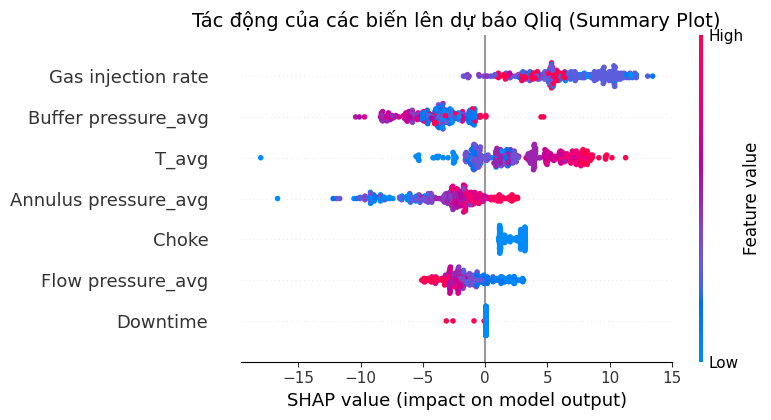

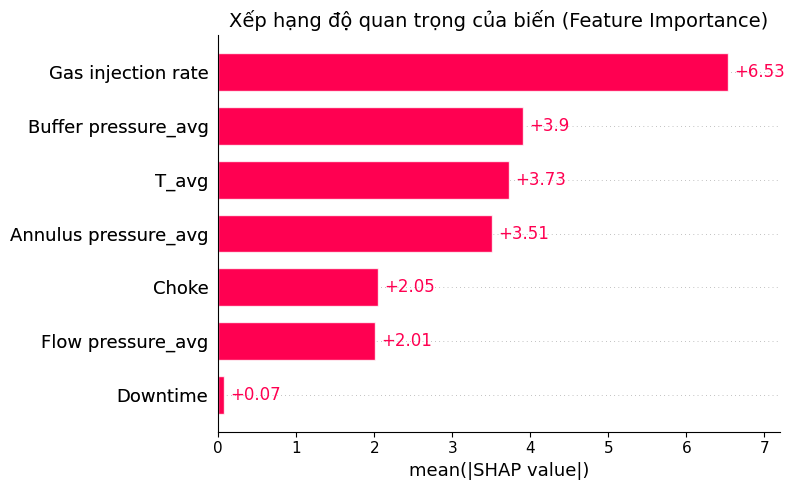

<Figure size 1000x600 with 0 Axes>

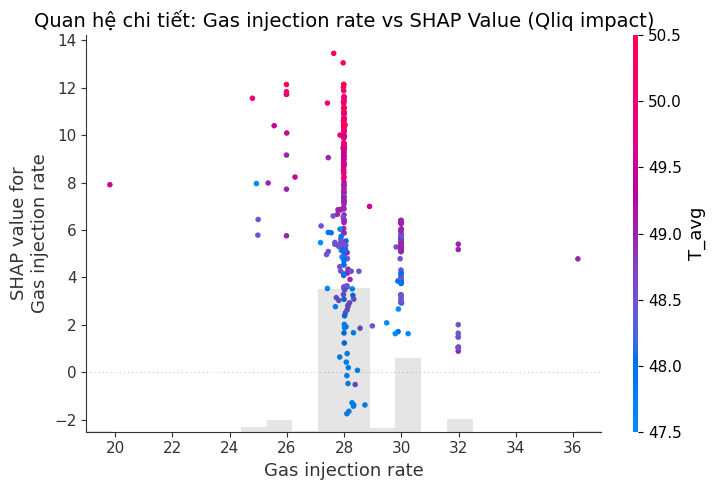


🔍 Giải thích mẫu dự báo đầu tiên (Index 0 trong X_test):
Giá trị thực tế (Qliq): 163.00
Giá trị dự báo (Qliq): 163.21


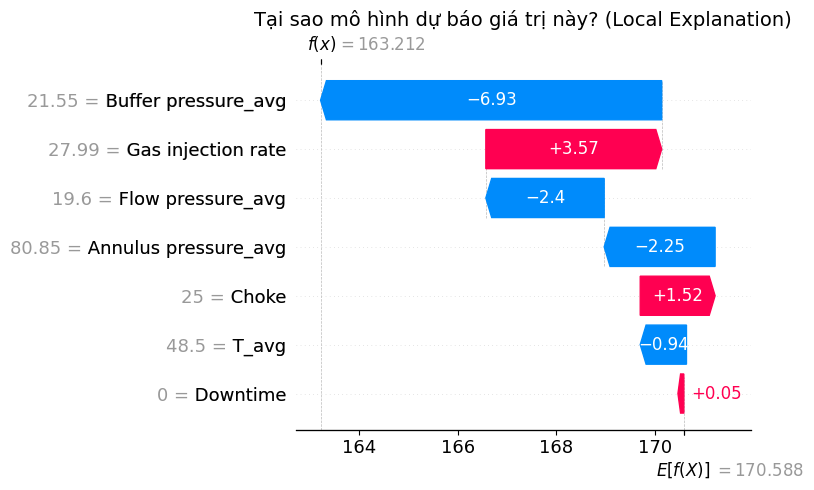

In [2]:
# ==========================================
# 7. PHÂN TÍCH SHAP (MODEL INTERPRETABILITY)
# ==========================================
import shap

# Cần khởi tạo javascript nếu chạy trên Jupyter/Colab
shap.initjs()

# 1. Tái tạo lại DataFrame cho X_test để hiển thị tên cột rõ ràng trên biểu đồ
# (Lúc train bạn dùng numpy array nên mất tên cột, giờ gán lại)
X_test_df = pd.DataFrame(X_test, columns=features)

print("⏳ Đang tính toán giá trị SHAP...")

# 2. Khởi tạo Explainer chuyên dụng cho Tree-based model (như LightGBM)
explainer = shap.TreeExplainer(model)

# 3. Tính giá trị SHAP
# shap_values sẽ chứa thông tin đóng góp của từng feature cho từng dự báo
shap_values = explainer(X_test_df)

# ==========================================
# 8. VẼ BIỂU ĐỒ SHAP
# ==========================================

# --- BIỂU ĐỒ 1: SUMMARY PLOT (QUAN TRỌNG NHẤT) ---
# Biểu đồ này cho biết feature nào quan trọng nhất và hướng ảnh hưởng (tăng hay giảm Qliq)
plt.figure(figsize=(10, 8))
plt.title("Tác động của các biến lên dự báo Qliq (Summary Plot)", fontsize=14)
shap.summary_plot(shap_values, X_test_df, show=False)
plt.tight_layout()
plt.show()

# --- BIỂU ĐỒ 2: BAR PLOT (XẾP HẠNG ĐỘ QUAN TRỌNG) ---
# Đơn giản hóa, chỉ xem biến nào đóng góp nhiều nhất vào độ lớn dự báo trung bình
plt.figure(figsize=(10, 6))
plt.title("Xếp hạng độ quan trọng của biến (Feature Importance)", fontsize=14)
shap.plots.bar(shap_values, max_display=10, show=False)
plt.tight_layout()
plt.show()

# --- BIỂU ĐỒ 3: DEPENDENCE PLOT (TƯƠNG TÁC BIẾN) ---
# Ví dụ: Xem tác động cụ thể của Gas injection rate lên Qliq
# Nó giúp bạn trả lời: "Bơm bao nhiêu gas thì hiệu quả bắt đầu giảm?"
target_feature = "Gas injection rate"
if target_feature in features:
    plt.figure(figsize=(10, 6))
    shap.plots.scatter(shap_values[:, target_feature], color=shap_values, show=False)
    plt.title(f"Quan hệ chi tiết: {target_feature} vs SHAP Value (Qliq impact)", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- BIỂU ĐỒ 4: WATERFALL PLOT (GIẢI THÍCH 1 MẪU CỤ THỂ) ---
# Giải thích tại sao mẫu đầu tiên trong tập test lại có kết quả dự báo như vậy
print(f"\n🔍 Giải thích mẫu dự báo đầu tiên (Index 0 trong X_test):")
print(f"Giá trị thực tế (Qliq): {y_test[0]:.2f}")
print(f"Giá trị dự báo (Qliq): {y_pred[0]:.2f}")

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0], show=False)
plt.title("Tại sao mô hình dự báo giá trị này? (Local Explanation)", fontsize=14)
plt.tight_layout()
plt.show()